In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
from tqdm.notebook import tqdm
import time
from IPython.display import clear_output

import ee, geemap

In [3]:
%load_ext autoreload
%autoreload 2
import sys  
sys.path.insert(0, '../../lib/')

In [4]:
%reload_ext autoreload
import sand_classification as sc
import quality_mosaic as qm

# Part I: Create Class Labels

## Read in the ground truth file

This contains the sieve size data that was originally used to train SediNet (Buscombe 2021)

In [10]:
#read the excel file called '../data/SediNet-training.xlsx' into a pandas dataframe called 'df
df = pd.read_excel('../../data/SediNet-training.xlsx')
df

,objectid,ATT ID,ImageName,Name,Coin,d10,d16,d25,d50,d65,d75,d84,d90,mean,Latitude,Longitude
0,1.0,1,ATT1_Sediment_Playa_Villa_Pesquera_Patillas_Pu...,PR001,quarter,0.112616,0.122476,0.134806,0.166364,0.198882,0.226864,0.249914,0.322672,0.172041,17.973859,-65.988747
1,2.0,2,ATT2_20200531_151022.jpg,PR002,dime,0.428245,0.452165,0.490573,0.606101,0.654565,0.689009,0.749384,0.815557,0.589995,18.458983,-65.986842
2,3.0,3,ATT3_IMG_20200619_123813.jpg,LB06192020 Swash,quarter,1.198173,1.047530,0.856321,0.698469,0.655920,0.629003,0.605724,0.591365,0.762423,40.284599,-73.981407
3,4.0,4,ATT4_2471FF73-CE00-470D-97F8-9F4169EF5546.jpeg,DSS Fordune,quarter,0.271014,0.301965,0.342689,0.396260,0.434992,0.478633,0.521641,0.552439,0.396676,38.665109,-75.067763
4,5.0,5,ATT5_C7809DDB-E022-45EA-9559-EA3F86F35B4B.jpeg,DSS berm/beach,quarter,0.295353,0.337247,0.375598,0.497587,0.606495,0.679202,0.774394,0.887155,0.506516,38.665189,-75.067055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,NaN,DK3,DK3_IMG_20200205_152945.jpg,"N. Indian River Inlet, DE Berm",quarter,0.216603,0.250342,0.289862,0.375094,0.401310,0.421517,0.484943,0.532444,0.357099,38.611033,-75.063257
66,NaN,DK4,DK4_IMG_20200205_153251.jpg,"N. Indian River Inlet, DE Dune Toe",quarter,0.266897,0.285153,0.314906,0.414869,0.474468,0.518180,0.560954,0.591414,0.404860,38.610892,-75.063450
67,213.0,DK5,DK5_IMG_20200205_153253.jpg,"N. Indian River Inlet, DE Dune Toe",quarter,0.266897,0.285153,0.314906,0.414869,0.474468,0.518180,0.560954,0.591414,0.404860,38.610892,-75.063450
68,215.0,DK6,DK6_IMG-0353.jpg,St Augustine Berm,quarter,0.199286,0.220408,0.243697,0.339142,0.397277,0.465445,0.574513,0.669973,0.350189,29.854100,-81.264700


In [11]:
#change the column 'objectid' to integer if it's not NaN
df['objectid'] = df['objectid'].astype('Int64')
df

,objectid,ATT ID,ImageName,Name,Coin,d10,d16,d25,d50,d65,d75,d84,d90,mean,Latitude,Longitude
0,1,1,ATT1_Sediment_Playa_Villa_Pesquera_Patillas_Pu...,PR001,quarter,0.112616,0.122476,0.134806,0.166364,0.198882,0.226864,0.249914,0.322672,0.172041,17.973859,-65.988747
1,2,2,ATT2_20200531_151022.jpg,PR002,dime,0.428245,0.452165,0.490573,0.606101,0.654565,0.689009,0.749384,0.815557,0.589995,18.458983,-65.986842
2,3,3,ATT3_IMG_20200619_123813.jpg,LB06192020 Swash,quarter,1.198173,1.047530,0.856321,0.698469,0.655920,0.629003,0.605724,0.591365,0.762423,40.284599,-73.981407
3,4,4,ATT4_2471FF73-CE00-470D-97F8-9F4169EF5546.jpeg,DSS Fordune,quarter,0.271014,0.301965,0.342689,0.396260,0.434992,0.478633,0.521641,0.552439,0.396676,38.665109,-75.067763
4,5,5,ATT5_C7809DDB-E022-45EA-9559-EA3F86F35B4B.jpeg,DSS berm/beach,quarter,0.295353,0.337247,0.375598,0.497587,0.606495,0.679202,0.774394,0.887155,0.506516,38.665189,-75.067055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,<NA>,DK3,DK3_IMG_20200205_152945.jpg,"N. Indian River Inlet, DE Berm",quarter,0.216603,0.250342,0.289862,0.375094,0.401310,0.421517,0.484943,0.532444,0.357099,38.611033,-75.063257
66,<NA>,DK4,DK4_IMG_20200205_153251.jpg,"N. Indian River Inlet, DE Dune Toe",quarter,0.266897,0.285153,0.314906,0.414869,0.474468,0.518180,0.560954,0.591414,0.404860,38.610892,-75.063450
67,213,DK5,DK5_IMG_20200205_153253.jpg,"N. Indian River Inlet, DE Dune Toe",quarter,0.266897,0.285153,0.314906,0.414869,0.474468,0.518180,0.560954,0.591414,0.404860,38.610892,-75.063450
68,215,DK6,DK6_IMG-0353.jpg,St Augustine Berm,quarter,0.199286,0.220408,0.243697,0.339142,0.397277,0.465445,0.574513,0.669973,0.350189,29.854100,-81.264700


In [12]:
#replace all values of 'objectid' that are NaN with 0
df['objectid'] = df['objectid'].fillna(0)


Check for outliers

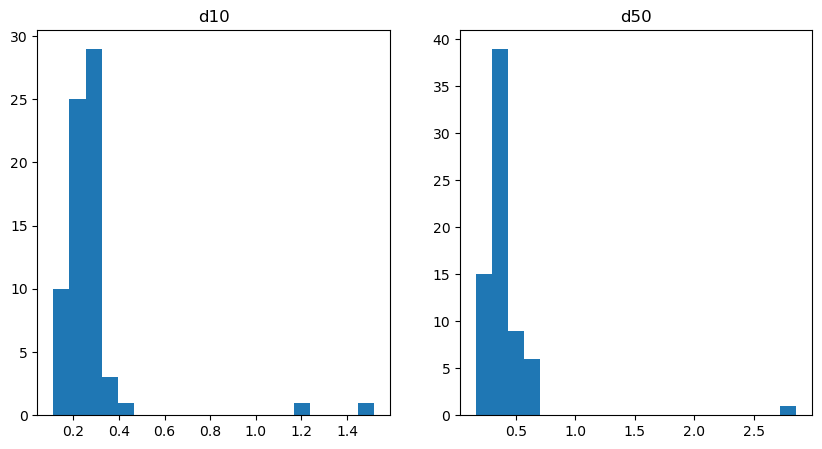

In [13]:
#create 2 histograms side by side for the columns 'd10' and 'd50' in df
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(df['d10'], bins=20)
ax1.set_title('d10')
ax2.hist(df['d50'], bins=20)
ax2.set_title('d50')
plt.show()


In [14]:
df[df.d10 > 1.0]

,objectid,ATT ID,ImageName,Name,Coin,d10,d16,d25,d50,d65,d75,d84,d90,mean,Latitude,Longitude
2,3,3,ATT3_IMG_20200619_123813.jpg,LB06192020 Swash,quarter,1.198173,1.047530,0.856321,0.698469,0.655920,0.629003,0.605724,0.591365,0.762423,40.284599,-73.981407
36,46,46,ATT46_IMG_20201015_102952510_HDR.jpg,Elwho Beach (spelling?) 15 Oct 2020,quarter,1.517215,1.784506,2.185454,2.857490,3.155398,3.379437,3.751294,4.044219,2.674410,48.149682,-123.555273


ObjectID #3 had a decreasing distribution: either it's reversed or garbage. Drop it!

In [15]:
#drop objetcid 3
df = df[df['objectid'] != 3]
len(df)


69

We also need to read in the SandSnap database to get the dates, since most of these datapoints are in that. This file does not have dates

So let's merge them

In [16]:
df_sandsnap = pd.read_csv('../../data/sandsnap-world.csv')
df_sandsnap

,objectid,GlobalID,City,Sample ID,Coin Reference,Location on Beach,Other,CreationDate,Creator,EditDate,...,coin_minor_axis_dim,blurry_metric,ab_value,pixel_count,reprocess_record,reprocess_all_records,Calculated Grain Size,Analysis Status,x,y
0,1,b751cc5c-4da0-4179-8aa9-09a076d39023,Patillas,PR001,quarter,the_swash,NaN,6/11/21 17:28,rose.dopsovic,2/28/22 18:43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-65.988747,17.973859
1,2,7cc3efe2-0597-4311-8727-eafcbd442b7f,Loiza,PR002,dime,the_berm,NaN,6/11/21 17:28,rose.dopsovic,2/28/22 18:43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-65.986842,18.458983
2,4,8548bce2-a7bb-4060-84ab-7977603a9185,Rehoboth DE Delaware State Seashore,DSS_foredune,quarter,the_dune,NaN,6/11/21 17:28,rose.dopsovic,2/28/22 18:43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-75.067763,38.665109
3,5,10e8ac4c-08a7-4389-828f-9178d03eb3e2,Rehoboth DE Delaware State Seashore,Dss_berm/beach,quarter,"the_berm,other",Beach,6/11/21 17:28,rose.dopsovic,2/28/22 18:43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-75.067055,38.665189
4,6,1bd95bf0-71eb-441a-8e07-fcdbf25f21c6,Rehoboth DE Delaware State Seashore,Dss-swash,quarter,the_swash,NaN,6/11/21 17:28,rose.dopsovic,2/28/22 18:43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-75.066829,38.665184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,1223,aa73d420-8cc1-4858-8333-5d4bd8142831,Vicksburg,Officelighttestelighttest5,nickel,other,NaN,3/10/23 16:11,NaN,3/10/23 16:13,...,NaN,NaN,NaN,NaN,NO,NaN,Pending Analysis,Pending Analysis,-90.866163,32.298973
768,1225,592e3c12-6bc2-4435-8cc0-099cdb1c2c98,Vicksburg,Officelighttestelighttest6,nickel,other,NaN,3/10/23 16:29,NaN,3/10/23 16:31,...,NaN,NaN,NaN,NaN,NO,NaN,Pending Analysis,Pending Analysis,-90.866163,32.298969
769,1226,dd0d8b2f-5e70-4c3f-8b10-6db5c8bf4dbc,Fort Pierce,NaN,nickel,the_dune,NaN,3/13/23 17:44,NaN,3/13/23 17:46,...,NaN,NaN,NaN,NaN,NO,NaN,Pending Analysis,Pending Analysis,-80.285356,27.451504
770,1227,f00e2e34-4409-45f8-8ea9-5479e6ecf386,Ft Pierce,NaN,nickel,the_berm,NaN,3/13/23 17:49,NaN,3/13/23 17:50,...,NaN,NaN,NaN,NaN,NO,NaN,Pending Analysis,Pending Analysis,-80.284365,27.452367


In [17]:
#merge df and df_sandsnap on the column 'objectid' but keep all rows from df only, discard rows from df_sandsnap that don't have a match in df
#keep only the column called 'Picture Date' from df_sandsnap
df_merged = df.merge(df_sandsnap[['objectid', 'Picture Date', 'Location on Beach', 'City']], on='objectid', how='left')
#rename the column 'Picture Date' to 'date'
df_merged = df_merged.rename(columns={'Picture Date': 'date', 'Location on Beach': 'location'})
df_merged

,objectid,ATT ID,ImageName,Name,Coin,d10,d16,d25,d50,d65,d75,d84,d90,mean,Latitude,Longitude,date,location,City
0,1,1,ATT1_Sediment_Playa_Villa_Pesquera_Patillas_Pu...,PR001,quarter,0.112616,0.122476,0.134806,0.166364,0.198882,0.226864,0.249914,0.322672,0.172041,17.973859,-65.988747,6/18/20 4:00,the_swash,Patillas
1,2,2,ATT2_20200531_151022.jpg,PR002,dime,0.428245,0.452165,0.490573,0.606101,0.654565,0.689009,0.749384,0.815557,0.589995,18.458983,-65.986842,6/15/20 4:00,the_berm,Loiza
2,4,4,ATT4_2471FF73-CE00-470D-97F8-9F4169EF5546.jpeg,DSS Fordune,quarter,0.271014,0.301965,0.342689,0.396260,0.434992,0.478633,0.521641,0.552439,0.396676,38.665109,-75.067763,6/22/20 4:00,the_dune,Rehoboth DE Delaware State Seashore
3,5,5,ATT5_C7809DDB-E022-45EA-9559-EA3F86F35B4B.jpeg,DSS berm/beach,quarter,0.295353,0.337247,0.375598,0.497587,0.606495,0.679202,0.774394,0.887155,0.506516,38.665189,-75.067055,6/22/20 4:00,"the_berm,other",Rehoboth DE Delaware State Seashore
4,6,6,ATT6_B803E195-0A46-4D78-9D45-CA9AEC58E277.jpeg,DSS Swash,quarter,0.267993,0.307443,0.361525,0.483608,0.614146,0.704910,0.810521,0.978358,0.493940,38.665184,-75.066829,6/22/20 4:00,the_swash,Rehoboth DE Delaware State Seashore
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,0,DK3,DK3_IMG_20200205_152945.jpg,"N. Indian River Inlet, DE Berm",quarter,0.216603,0.250342,0.289862,0.375094,0.401310,0.421517,0.484943,0.532444,0.357099,38.611033,-75.063257,NaN,NaN,NaN
65,0,DK4,DK4_IMG_20200205_153251.jpg,"N. Indian River Inlet, DE Dune Toe",quarter,0.266897,0.285153,0.314906,0.414869,0.474468,0.518180,0.560954,0.591414,0.404860,38.610892,-75.063450,NaN,NaN,NaN
66,213,DK5,DK5_IMG_20200205_153253.jpg,"N. Indian River Inlet, DE Dune Toe",quarter,0.266897,0.285153,0.314906,0.414869,0.474468,0.518180,0.560954,0.591414,0.404860,38.610892,-75.063450,2/12/20 5:00,the_dune,Rehoboth Beach
67,215,DK6,DK6_IMG-0353.jpg,St Augustine Berm,quarter,0.199286,0.220408,0.243697,0.339142,0.397277,0.465445,0.574513,0.669973,0.350189,29.854100,-81.264700,3/11/20 4:00,the_berm,St. Augustine


## Missing dates

Manual checks on the database show that the IDs grouped closer together happen to happen around the same time. We can use this assumption to backfill dates

In [18]:
#find all the rows in df_merged where the column 'date' is NaN
missing_dates = df_merged[df_merged['date'].isna()].index.to_list()
# for any rows that have NaN in the column 'date', replace the value with the value in the column 'date' of the row closest to it that has a value in the column 'date'
df_merged['date'] = df_merged['date'].fillna(method='ffill')

#print the rows whose index matches missin_dates
df_merged.loc[missing_dates]

,objectid,ATT ID,ImageName,Name,Coin,d10,d16,d25,d50,d65,d75,d84,d90,mean,Latitude,Longitude,date,location,City
21,28,28,ATT28_IMG_20200902_094947.jpg,Nesk 3 Above Rockline (MHHW),quarter,0.219983,0.230262,0.246590,0.271602,0.286972,0.298185,0.317868,0.331707,0.270895,45.137821,-123.976653,9/2/20 4:00,NaN,NaN
22,29,29,ATT29_IMG_20200902_095430.jpg,Nesk 4 (Above rockline),quarter,0.258710,0.272155,0.293644,0.329261,0.351446,0.377384,0.403547,0.432576,0.330687,45.131877,-123.978318,9/2/20 4:00,NaN,NaN
30,37,37,ATT37_IMG_20200903_104146.jpg,Nesk 11 (Rockline),quarter,0.245652,0.257640,0.273124,0.311133,0.329525,0.342386,0.357772,0.387967,0.306094,45.181050,-123.970187,9/11/20 4:00,NaN,NaN
38,50,50,ATT50_16040097178737819159967641904657.jpg,Malibu Corral Beach,quarter,0.272783,0.305846,0.339828,0.455169,0.542039,0.610033,0.682504,0.769506,0.456310,34.076104,-117.203972,10/27/20 4:00,NaN,NaN
40,52,52,ATT52_16046158662007690554262945538181.jpg,Zuma Beach Malibu,quarter,0.154358,0.182762,0.214214,0.237397,0.256129,0.278105,0.305130,0.361052,0.236564,34.021950,-118.831760,10/29/20 4:00,NaN,NaN
51,0,87,ATT87_234C0D33-6A44-4460-A75F-C69D79B2985C.jpeg,"PBCK53021 Pensacola Beach, Fl Gulf Side",quarter,0.299964,0.314855,0.338590,0.404502,0.461502,0.509018,0.555951,0.589620,0.413704,30.325540,-87.179350,3/13/21 5:00,NaN,NaN
55,300,BM1,BM1_3339CF1F-C644-4D55-B0A5-DED60F28A319.jpeg,Anna Maria Island FL. Holmes Beach #ACF91564.1...,quarter,0.151583,0.172495,0.198377,0.264194,0.388519,0.634435,0.952099,1.234602,0.351394,27.498464,-82.713626,6/28/21 4:00,the_berm,Anna Maria Island
56,307,BM2,BM2_IMG_20200129_103207.jpg,01282020 Boynton Inlet,quarter,0.273080,0.305711,0.352155,0.417699,0.506273,0.576716,0.661626,0.750524,0.438796,26.544083,-80.043510,6/28/21 4:00,the_berm,Boynton Beach
57,303,BM3,BM3_IMG_20200129_083839.jpg,"01282020Delray Beach, FL",quarter,0.241002,0.263953,0.297877,0.386438,0.444860,0.517894,0.593823,0.663251,0.392724,26.441283,-80.060453,6/28/21 4:00,the_berm,Delray Beach
58,305,BM4,BM4_IMG_20200129_091029.jpg,01282020Delray Beach 3,quarter,0.270351,0.303577,0.346965,0.418111,0.505912,0.575197,0.658036,0.742721,0.437123,26.472315,-80.055729,6/28/21 4:00,the_berm,Delray Beach


In [19]:
#convert the column 'date' to a datetime object
df_merged['date'] = pd.to_datetime(df_merged['date'])
#convert the column 'date' to a string in the format '%Y-%m-%d' 
df_merged['date'] = df_merged['date'].dt.strftime('%Y-%m-%d')
df_merged

,objectid,ATT ID,ImageName,Name,Coin,d10,d16,d25,d50,d65,d75,d84,d90,mean,Latitude,Longitude,date,location,City
0,1,1,ATT1_Sediment_Playa_Villa_Pesquera_Patillas_Pu...,PR001,quarter,0.112616,0.122476,0.134806,0.166364,0.198882,0.226864,0.249914,0.322672,0.172041,17.973859,-65.988747,2020-06-18,the_swash,Patillas
1,2,2,ATT2_20200531_151022.jpg,PR002,dime,0.428245,0.452165,0.490573,0.606101,0.654565,0.689009,0.749384,0.815557,0.589995,18.458983,-65.986842,2020-06-15,the_berm,Loiza
2,4,4,ATT4_2471FF73-CE00-470D-97F8-9F4169EF5546.jpeg,DSS Fordune,quarter,0.271014,0.301965,0.342689,0.396260,0.434992,0.478633,0.521641,0.552439,0.396676,38.665109,-75.067763,2020-06-22,the_dune,Rehoboth DE Delaware State Seashore
3,5,5,ATT5_C7809DDB-E022-45EA-9559-EA3F86F35B4B.jpeg,DSS berm/beach,quarter,0.295353,0.337247,0.375598,0.497587,0.606495,0.679202,0.774394,0.887155,0.506516,38.665189,-75.067055,2020-06-22,"the_berm,other",Rehoboth DE Delaware State Seashore
4,6,6,ATT6_B803E195-0A46-4D78-9D45-CA9AEC58E277.jpeg,DSS Swash,quarter,0.267993,0.307443,0.361525,0.483608,0.614146,0.704910,0.810521,0.978358,0.493940,38.665184,-75.066829,2020-06-22,the_swash,Rehoboth DE Delaware State Seashore
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,0,DK3,DK3_IMG_20200205_152945.jpg,"N. Indian River Inlet, DE Berm",quarter,0.216603,0.250342,0.289862,0.375094,0.401310,0.421517,0.484943,0.532444,0.357099,38.611033,-75.063257,2020-02-12,NaN,NaN
65,0,DK4,DK4_IMG_20200205_153251.jpg,"N. Indian River Inlet, DE Dune Toe",quarter,0.266897,0.285153,0.314906,0.414869,0.474468,0.518180,0.560954,0.591414,0.404860,38.610892,-75.063450,2020-02-12,NaN,NaN
66,213,DK5,DK5_IMG_20200205_153253.jpg,"N. Indian River Inlet, DE Dune Toe",quarter,0.266897,0.285153,0.314906,0.414869,0.474468,0.518180,0.560954,0.591414,0.404860,38.610892,-75.063450,2020-02-12,the_dune,Rehoboth Beach
67,215,DK6,DK6_IMG-0353.jpg,St Augustine Berm,quarter,0.199286,0.220408,0.243697,0.339142,0.397277,0.465445,0.574513,0.669973,0.350189,29.854100,-81.264700,2020-03-11,the_berm,St. Augustine


In [20]:
assert(len(df_merged[df_merged['date'].isna() | df_merged['Longitude'].isna() | df_merged['Latitude'].isna()]) == 0)

In [21]:
#look for any NaN values in the column 'date' or 'Longitude' or 'Latitude' in df_merged and drop them
df_merged = df_merged.dropna(subset=['date', 'Longitude', 'Latitude']).reset_index(drop=True)
df_merged

,objectid,ATT ID,ImageName,Name,Coin,d10,d16,d25,d50,d65,d75,d84,d90,mean,Latitude,Longitude,date,location,City
0,1,1,ATT1_Sediment_Playa_Villa_Pesquera_Patillas_Pu...,PR001,quarter,0.112616,0.122476,0.134806,0.166364,0.198882,0.226864,0.249914,0.322672,0.172041,17.973859,-65.988747,2020-06-18,the_swash,Patillas
1,2,2,ATT2_20200531_151022.jpg,PR002,dime,0.428245,0.452165,0.490573,0.606101,0.654565,0.689009,0.749384,0.815557,0.589995,18.458983,-65.986842,2020-06-15,the_berm,Loiza
2,4,4,ATT4_2471FF73-CE00-470D-97F8-9F4169EF5546.jpeg,DSS Fordune,quarter,0.271014,0.301965,0.342689,0.396260,0.434992,0.478633,0.521641,0.552439,0.396676,38.665109,-75.067763,2020-06-22,the_dune,Rehoboth DE Delaware State Seashore
3,5,5,ATT5_C7809DDB-E022-45EA-9559-EA3F86F35B4B.jpeg,DSS berm/beach,quarter,0.295353,0.337247,0.375598,0.497587,0.606495,0.679202,0.774394,0.887155,0.506516,38.665189,-75.067055,2020-06-22,"the_berm,other",Rehoboth DE Delaware State Seashore
4,6,6,ATT6_B803E195-0A46-4D78-9D45-CA9AEC58E277.jpeg,DSS Swash,quarter,0.267993,0.307443,0.361525,0.483608,0.614146,0.704910,0.810521,0.978358,0.493940,38.665184,-75.066829,2020-06-22,the_swash,Rehoboth DE Delaware State Seashore
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,0,DK3,DK3_IMG_20200205_152945.jpg,"N. Indian River Inlet, DE Berm",quarter,0.216603,0.250342,0.289862,0.375094,0.401310,0.421517,0.484943,0.532444,0.357099,38.611033,-75.063257,2020-02-12,NaN,NaN
65,0,DK4,DK4_IMG_20200205_153251.jpg,"N. Indian River Inlet, DE Dune Toe",quarter,0.266897,0.285153,0.314906,0.414869,0.474468,0.518180,0.560954,0.591414,0.404860,38.610892,-75.063450,2020-02-12,NaN,NaN
66,213,DK5,DK5_IMG_20200205_153253.jpg,"N. Indian River Inlet, DE Dune Toe",quarter,0.266897,0.285153,0.314906,0.414869,0.474468,0.518180,0.560954,0.591414,0.404860,38.610892,-75.063450,2020-02-12,the_dune,Rehoboth Beach
67,215,DK6,DK6_IMG-0353.jpg,St Augustine Berm,quarter,0.199286,0.220408,0.243697,0.339142,0.397277,0.465445,0.574513,0.669973,0.350189,29.854100,-81.264700,2020-03-11,the_berm,St. Augustine


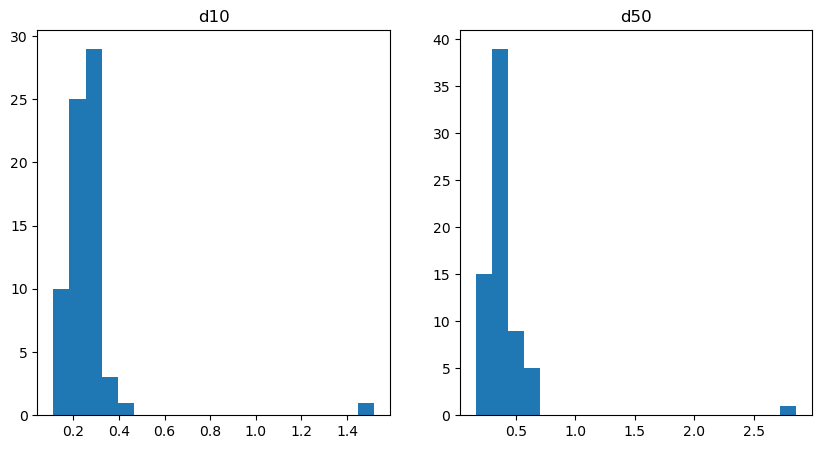

In [22]:
#create 2 histograms side by side for the columns 'd10' and 'd50' in df
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(df_merged['d10'], bins=20)
ax1.set_title('d10')
ax2.hist(df_merged['d50'], bins=20)
ax2.set_title('d50')
plt.show()

In [23]:
df_merged[df_merged.d50 > 1.0]

,objectid,ATT ID,ImageName,Name,Coin,d10,d16,d25,d50,d65,d75,d84,d90,mean,Latitude,Longitude,date,location,City
35,46,46,ATT46_IMG_20201015_102952510_HDR.jpg,Elwho Beach (spelling?) 15 Oct 2020,quarter,1.517215,1.784506,2.185454,2.85749,3.155398,3.379437,3.751294,4.044219,2.67441,48.149682,-123.555273,2020-10-15,the_swash,Port Angeles


## What is sand

Let's first define what sand is


### Version A: Fineness Modulus (FM) based Berkeley Recommendation
FM = SUM(% cumulative passing sieve) / 100

Where sieve sizes are defines in the table below
| Sieve Number      | Diameter |
| ----------- | ----------- |
| #?      | 10mm       |
| #4      | 4.75mm       |
| #8      | 2.36mm       |
| #16      | 1.18mm       |
| #30      | 0.60mm       |
| #100      | 0.150mm       |

The Berkeley Sand Project has concluded that this is the valid/loosest range for what is considered sand:


$\boldsymbol{1.71\leq FM\leq 4}$

In [24]:
fm_df = sc.assign_FM_classes(df_merged)
fm_df

,objectid,ATT ID,ImageName,Name,Coin,d10,d16,d25,d50,d65,...,mean,Latitude,Longitude,date,location,City,FM,r2_fm,stderr_fm,FM_class
0,1,1,ATT1_Sediment_Playa_Villa_Pesquera_Patillas_Pu...,PR001,quarter,0.112616,0.122476,0.134806,0.166364,0.198882,...,0.172041,17.973859,-65.988747,2020-06-18,the_swash,Patillas,0.689146,0.896457,57.160041,fine
1,2,2,ATT2_20200531_151022.jpg,PR002,dime,0.428245,0.452165,0.490573,0.606101,0.654565,...,0.589995,18.458983,-65.986842,2020-06-15,the_berm,Loiza,2.504750,0.985257,10.968534,sand
2,4,4,ATT4_2471FF73-CE00-470D-97F8-9F4169EF5546.jpeg,DSS Fordune,quarter,0.271014,0.301965,0.342689,0.396260,0.434992,...,0.396676,38.665109,-75.067763,2020-06-22,the_dune,Rehoboth DE Delaware State Seashore,1.823772,0.983183,16.262802,sand
3,5,5,ATT5_C7809DDB-E022-45EA-9559-EA3F86F35B4B.jpeg,DSS berm/beach,quarter,0.295353,0.337247,0.375598,0.497587,0.606495,...,0.506516,38.665189,-75.067055,2020-06-22,"the_berm,other",Rehoboth DE Delaware State Seashore,2.268347,0.966019,10.981223,sand
4,6,6,ATT6_B803E195-0A46-4D78-9D45-CA9AEC58E277.jpeg,DSS Swash,quarter,0.267993,0.307443,0.361525,0.483608,0.614146,...,0.493940,38.665184,-75.066829,2020-06-22,the_swash,Rehoboth DE Delaware State Seashore,2.223582,0.947849,11.520828,sand
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,0,DK3,DK3_IMG_20200205_152945.jpg,"N. Indian River Inlet, DE Berm",quarter,0.216603,0.250342,0.289862,0.375094,0.401310,...,0.357099,38.611033,-75.063257,2020-02-12,NaN,NaN,1.680223,0.973488,18.744849,fine
65,0,DK4,DK4_IMG_20200205_153251.jpg,"N. Indian River Inlet, DE Dune Toe",quarter,0.266897,0.285153,0.314906,0.414869,0.474468,...,0.404860,38.610892,-75.063450,2020-02-12,NaN,NaN,1.855669,0.997619,4.922383,sand
66,213,DK5,DK5_IMG_20200205_153253.jpg,"N. Indian River Inlet, DE Dune Toe",quarter,0.266897,0.285153,0.314906,0.414869,0.474468,...,0.404860,38.610892,-75.063450,2020-02-12,the_dune,Rehoboth Beach,1.855669,0.997619,4.922383,sand
67,215,DK6,DK6_IMG-0353.jpg,St Augustine Berm,quarter,0.199286,0.220408,0.243697,0.339142,0.397277,...,0.350189,29.854100,-81.264700,2020-03-11,the_berm,St. Augustine,1.648498,0.925566,20.407662,fine


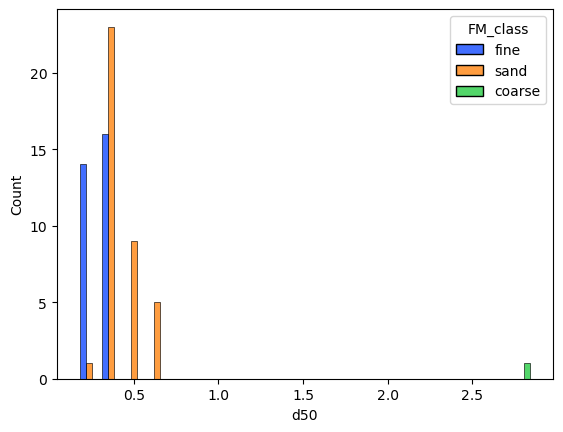

In [25]:
#seaborn histogram for FM, with colors for each FM class
sns.histplot(data=fm_df, x='d50', hue='FM_class',bins=20 , shrink=0.8, multiple='dodge', palette='bright')
plt.show()

### Version B: UNEP-GRID Recommendations

### Sand:
50% or more is smaller than 4.75mm & 15% or less is smaller than 0.075mm

### Gravel:
100% smaller than 75mm, and atleast 50% is larger than 4.75mm & 15% or less is smaller than 0.075mm


In [26]:
grid_df = sc.assign_grid_classes(fm_df)
grid_df

,objectid,ATT ID,ImageName,Name,Coin,d10,d16,d25,d50,d65,...,FM,r2_fm,stderr_fm,FM_class,D75,D4_75,D_075,r2_grid,stderr_grid,grid_class
0,1,1,ATT1_Sediment_Playa_Villa_Pesquera_Patillas_Pu...,PR001,quarter,0.112616,0.122476,0.134806,0.166364,0.198882,...,0.689146,0.896457,57.160041,fine,100.0,100.0,3.746088,0.896457,57.160041,sand
1,2,2,ATT2_20200531_151022.jpg,PR002,dime,0.428245,0.452165,0.490573,0.606101,0.654565,...,2.504750,0.985257,10.968534,sand,100.0,100.0,0.000000,0.985257,10.968534,sand
2,4,4,ATT4_2471FF73-CE00-470D-97F8-9F4169EF5546.jpeg,DSS Fordune,quarter,0.271014,0.301965,0.342689,0.396260,0.434992,...,1.823772,0.983183,16.262802,sand,100.0,100.0,0.000000,0.983183,16.262802,sand
3,5,5,ATT5_C7809DDB-E022-45EA-9559-EA3F86F35B4B.jpeg,DSS berm/beach,quarter,0.295353,0.337247,0.375598,0.497587,0.606495,...,2.268347,0.966019,10.981223,sand,100.0,100.0,0.000000,0.966019,10.981223,sand
4,6,6,ATT6_B803E195-0A46-4D78-9D45-CA9AEC58E277.jpeg,DSS Swash,quarter,0.267993,0.307443,0.361525,0.483608,0.614146,...,2.223582,0.947849,11.520828,sand,100.0,100.0,0.000000,0.947849,11.520828,sand
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,0,DK3,DK3_IMG_20200205_152945.jpg,"N. Indian River Inlet, DE Berm",quarter,0.216603,0.250342,0.289862,0.375094,0.401310,...,1.680223,0.973488,18.744849,fine,100.0,100.0,0.000000,0.973488,18.744849,sand
65,0,DK4,DK4_IMG_20200205_153251.jpg,"N. Indian River Inlet, DE Dune Toe",quarter,0.266897,0.285153,0.314906,0.414869,0.474468,...,1.855669,0.997619,4.922383,sand,100.0,100.0,0.000000,0.997619,4.922383,sand
66,213,DK5,DK5_IMG_20200205_153253.jpg,"N. Indian River Inlet, DE Dune Toe",quarter,0.266897,0.285153,0.314906,0.414869,0.474468,...,1.855669,0.997619,4.922383,sand,100.0,100.0,0.000000,0.997619,4.922383,sand
67,215,DK6,DK6_IMG-0353.jpg,St Augustine Berm,quarter,0.199286,0.220408,0.243697,0.339142,0.397277,...,1.648498,0.925566,20.407662,fine,100.0,100.0,0.000000,0.925566,20.407662,sand


## Compare FM based recommendations v/s UNEP-GRID based recommendations

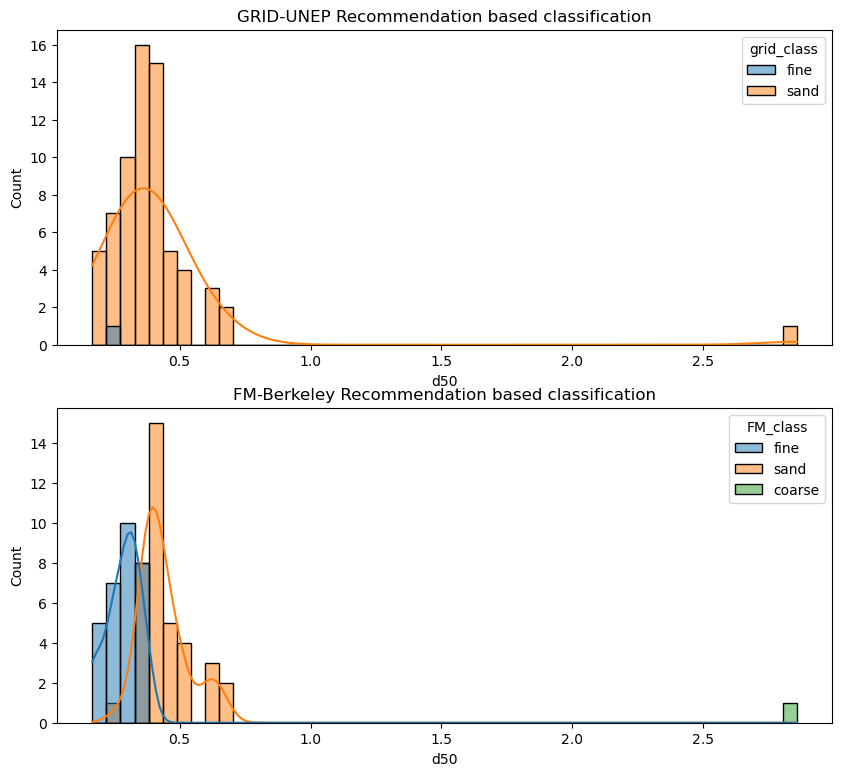

In [27]:
fig, axs = plt.subplots(2, 1, figsize=(10, 9))

sns.histplot(data=grid_df, x="d50",hue='grid_class' , kde=True, color=["skyblue","yellow"], ax=axs[0], label='grid', hue_order=['fine','sand'])
sns.histplot(data=grid_df, x="d50",hue='FM_class', kde=True, color=["skyblue","yellow"], ax=axs[1],hue_order=['fine','sand','coarse'])
axs[0].set_title('GRID-UNEP Recommendation based classification')
axs[1].set_title('FM-Berkeley Recommendation based classification')
plt.show()

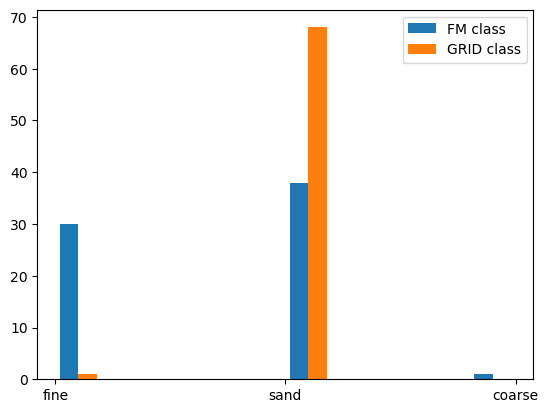

In [28]:
plt.hist([grid_df.FM_class, grid_df.grid_class])
plt.legend(['FM class', 'GRID class'])
plt.show()

## Convert to lib friendly columns

In [29]:
grid_df.columns

Index(['objectid', 'ATT ID', 'ImageName', 'Name', 'Coin', 'd10', 'd16', 'd25',
       'd50', 'd65', 'd75', 'd84', 'd90', 'mean', 'Latitude', 'Longitude',
       'date', 'location', 'City', 'FM', 'r2_fm', 'stderr_fm', 'FM_class',
       'D75', 'D4_75', 'D_075', 'r2_grid', 'stderr_grid', 'grid_class'],
      dtype='object')

In [48]:
#change the names of the columns 'date' to 'Date' , 'grid_class' to 'Class'
df = grid_df.rename(columns={'date': 'Date', 'grid_class': 'Class'}).reset_index(drop=True)

#create a new column called 'ID' that is the index of the row and append the string 'sedinet-' to the beginning of each value
df['ID'] = 'sedinet-' + df.index.astype(str)

#drop objectid
df = df.drop(columns=['objectid'])

df['Source'] = 'https://onlinelibrary.wiley.com/doi/abs/10.1002/esp.4760'
df['Site'] = 'Coastal'

#move the column 'ID' 'Latitude' 'Longitude' 'Class' to the first position in the dataframe
# to the first position in the dataframe
# cols = df.columns.tolist()
cols_at_start = ['ID', 'Latitude', 'Longitude', 'Class','Date', 'Site']

# df[cols_at_start + [c for c in df if c not in cols_at_start]]

df = df[[c for c in cols_at_start if c in df] +
        [c for c in df if c not in cols_at_start]]

df

,ID,Latitude,Longitude,Class,Date,Site,ATT ID,ImageName,Name,Coin,...,FM,r2_fm,stderr_fm,FM_class,D75,D4_75,D_075,r2_grid,stderr_grid,Source
0,sedinet-0,17.973859,-65.988747,sand,2020-06-18,Coastal,1,ATT1_Sediment_Playa_Villa_Pesquera_Patillas_Pu...,PR001,quarter,...,0.689146,0.896457,57.160041,fine,100.0,100.0,3.746088,0.896457,57.160041,https://onlinelibrary.wiley.com/doi/abs/10.100...
1,sedinet-1,18.458983,-65.986842,sand,2020-06-15,Coastal,2,ATT2_20200531_151022.jpg,PR002,dime,...,2.504750,0.985257,10.968534,sand,100.0,100.0,0.000000,0.985257,10.968534,https://onlinelibrary.wiley.com/doi/abs/10.100...
2,sedinet-2,38.665109,-75.067763,sand,2020-06-22,Coastal,4,ATT4_2471FF73-CE00-470D-97F8-9F4169EF5546.jpeg,DSS Fordune,quarter,...,1.823772,0.983183,16.262802,sand,100.0,100.0,0.000000,0.983183,16.262802,https://onlinelibrary.wiley.com/doi/abs/10.100...
3,sedinet-3,38.665189,-75.067055,sand,2020-06-22,Coastal,5,ATT5_C7809DDB-E022-45EA-9559-EA3F86F35B4B.jpeg,DSS berm/beach,quarter,...,2.268347,0.966019,10.981223,sand,100.0,100.0,0.000000,0.966019,10.981223,https://onlinelibrary.wiley.com/doi/abs/10.100...
4,sedinet-4,38.665184,-75.066829,sand,2020-06-22,Coastal,6,ATT6_B803E195-0A46-4D78-9D45-CA9AEC58E277.jpeg,DSS Swash,quarter,...,2.223582,0.947849,11.520828,sand,100.0,100.0,0.000000,0.947849,11.520828,https://onlinelibrary.wiley.com/doi/abs/10.100...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,sedinet-64,38.611033,-75.063257,sand,2020-02-12,Coastal,DK3,DK3_IMG_20200205_152945.jpg,"N. Indian River Inlet, DE Berm",quarter,...,1.680223,0.973488,18.744849,fine,100.0,100.0,0.000000,0.973488,18.744849,https://onlinelibrary.wiley.com/doi/abs/10.100...
65,sedinet-65,38.610892,-75.063450,sand,2020-02-12,Coastal,DK4,DK4_IMG_20200205_153251.jpg,"N. Indian River Inlet, DE Dune Toe",quarter,...,1.855669,0.997619,4.922383,sand,100.0,100.0,0.000000,0.997619,4.922383,https://onlinelibrary.wiley.com/doi/abs/10.100...
66,sedinet-66,38.610892,-75.063450,sand,2020-02-12,Coastal,DK5,DK5_IMG_20200205_153253.jpg,"N. Indian River Inlet, DE Dune Toe",quarter,...,1.855669,0.997619,4.922383,sand,100.0,100.0,0.000000,0.997619,4.922383,https://onlinelibrary.wiley.com/doi/abs/10.100...
67,sedinet-67,29.854100,-81.264700,sand,2020-03-11,Coastal,DK6,DK6_IMG-0353.jpg,St Augustine Berm,quarter,...,1.648498,0.925566,20.407662,fine,100.0,100.0,0.000000,0.925566,20.407662,https://onlinelibrary.wiley.com/doi/abs/10.100...


### Save the file as a csv

In [50]:
#save fm_df to a csv file
df.to_csv('../../data/sedinet-gt-fm.csv')
#save fm_df to a pickle file
df.to_pickle('../../data/sedinet-gt-fm.pkl')

## Part I Conclusion


The GRID-UNEP Recommendations seem much looser than our own FM based ones (based on IS383 recommendations from India)

That concludes this investigation. The next step is to select some subset and validate the actual location of these images on a S-2 map

# Part II: Select subset for training

Here we iterate over the df and iteratively pick and adjust the locations we want to keep

In [5]:
# df = pd.read_csv('../../data/sedinet-gt-fm.csv')
df = pd.read_excel('../../data/labels/gt-bands.xlsx', sheet_name='sedinet')
df

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Latitude,Longitude,Class,Date,Site,...,B11_mean,B12_mean,VV_mean,VH_mean,mTGSI_mean,BSI_mean,NDWI_mean,keep,location_tweaked,class_code
0,0,0,0,0,sedinet-0,17.973859,-65.988747,sand,2020-06-18,Coastal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,99
1,1,1,1,1,sedinet-1,18.459221,-65.987196,sand,2020-06-15,Coastal,...,2754.255127,2127.833740,-12.245424,-19.858164,-0.011403,0.046433,-0.133137,True,True,1
2,2,2,2,2,sedinet-2,38.665018,-75.067643,sand,2020-06-22,Coastal,...,5267.705566,5056.720703,-15.439523,-21.776503,0.089654,0.120402,-0.217234,True,True,1
3,3,3,3,3,sedinet-3,38.665267,-75.067228,sand,2020-06-22,Coastal,...,6080.360352,6131.175781,-18.035833,-26.745705,0.124123,0.145531,-0.176357,True,True,1
4,4,4,4,4,sedinet-4,38.665184,-75.066829,sand,2020-06-22,Coastal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,64,64,64,64,sedinet-64,38.611033,-75.063257,sand,2020-02-12,Coastal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,99
65,65,65,65,65,sedinet-65,38.610892,-75.063450,sand,2020-02-12,Coastal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,99
66,66,66,66,66,sedinet-66,38.610892,-75.063450,sand,2020-02-12,Coastal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,99
67,67,67,67,67,sedinet-67,29.854100,-81.264700,sand,2020-03-11,Coastal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,99


In [6]:
ee.Initialize()

In [7]:
INDEX = 59

In [8]:
output = df.copy()

In [27]:

sampling_buffer_m = 5

Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [30]:
s1_s2, sample = qm.get_s1s2_data(output, Map, INDEX, display_smap=True, mosaic_method='qm', sampling_buffer_m=sampling_buffer_m, median_samples=5,roi_buffer_m=400, obia=True)

Index:  68  ID:  sedinet-68 Class:  sand  Site:  Coastal
Search window from 2019-09-11 to 2020-09-11


Map(center=[29.854200011116017, -81.26549991652608], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Use this immediately after the map is refreshed to either select or discard the sample

INDEX will auto update on calling this function

In [31]:
output, INDEX = qm.get_training_sample(output, s1_s2, sample, Map, INDEX, display_clusters=False, obia=True)
output.to_excel('../../data/labels/gt-bands.xlsx', sheet_name='sedinet')
output.iloc[INDEX-1]

New marker accepted
Kept Observation


Unnamed: 0.3                                                       68
Unnamed: 0.2                                                       68
Unnamed: 0.1                                                       68
Unnamed: 0                                                         68
ID                                                         sedinet-68
Latitude                                                    29.854849
Longitude                                                  -81.265225
Class                                                            sand
Date                                                       2020-03-11
Site                                                          Coastal
ATT ID                                                            DK7
ImageName                                            DK7_IMG-0360.jpg
Name                                                St Augustine Dune
Coin                                                          quarter
d10                 

## Save to excel sheet

In [14]:
display(output)
#save to excel sheet with sheet name 'sedinet'
output.to_excel('../../data/labels/gt-bands.xlsx', sheet_name='sedinet')

,Unnamed: 0.1,Unnamed: 0,ID,Latitude,Longitude,Class,Date,Site,ATT ID,ImageName,...,B11_mean,B12_mean,VV_mean,VH_mean,mTGSI_mean,BSI_mean,NDWI_mean,keep,location_tweaked,class_code
0,0,0,sedinet-0,17.973859,-65.988747,sand,2020-06-18,Coastal,1,ATT1_Sediment_Playa_Villa_Pesquera_Patillas_Pu...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,99
1,1,1,sedinet-1,18.459221,-65.987196,sand,2020-06-15,Coastal,2,ATT2_20200531_151022.jpg,...,2754.255127,2127.833740,-12.245424,-19.858164,-0.011403,0.046433,-0.133137,True,True,1
2,2,2,sedinet-2,38.665018,-75.067643,sand,2020-06-22,Coastal,4,ATT4_2471FF73-CE00-470D-97F8-9F4169EF5546.jpeg,...,5267.705566,5056.720703,-15.439523,-21.776503,0.089654,0.120402,-0.217234,True,True,1
3,3,3,sedinet-3,38.665267,-75.067228,sand,2020-06-22,Coastal,5,ATT5_C7809DDB-E022-45EA-9559-EA3F86F35B4B.jpeg,...,6080.360352,6131.175781,-18.035833,-26.745705,0.124123,0.145531,-0.176357,True,True,1
4,4,4,sedinet-4,38.665184,-75.066829,sand,2020-06-22,Coastal,6,ATT6_B803E195-0A46-4D78-9D45-CA9AEC58E277.jpeg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,64,64,sedinet-64,38.611033,-75.063257,sand,2020-02-12,Coastal,DK3,DK3_IMG_20200205_152945.jpg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,99
65,65,65,sedinet-65,38.610892,-75.063450,sand,2020-02-12,Coastal,DK4,DK4_IMG_20200205_153251.jpg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,99
66,66,66,sedinet-66,38.610892,-75.063450,sand,2020-02-12,Coastal,DK5,DK5_IMG_20200205_153253.jpg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,99
67,67,67,sedinet-67,29.854100,-81.264700,sand,2020-03-11,Coastal,DK6,DK6_IMG-0353.jpg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,99


In [63]:
output.to_csv('../../data/sedinet-gt-final-locations.csv')
#save fm_df to a pickle file
output.to_pickle('../../data/sedinet-gt-final-locations.pkl')